In [14]:
pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------- ----------------------------- 2.1/8.1 MB 11.8 MB/s eta 0:00:01
   ---------------- ----------------------- 3.4/8.1 MB 9.1 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 9.6 MB/s eta 0:00:01
   ---------------------------------------  7.9/8.1 MB 9.7 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 9.2 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   -------------------------------------- - 2.1/2.2 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------------------------------- ---- 2.4/2.7 MB 12.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 11.0 MB/s 

In [15]:
import ijson
import random
import re
import pandas as pd
import json
from tqdm import tqdm
import pprint
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



filename = "pyedur_full.jsonl"

In [2]:
def print_line(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        for i in range(random.randint(0,1630607)):
            f.readline()
        pprint.pp(f.readline())


def num_rows(file_path):
    count = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for _ in f:
            count += 1

    print(f'Total number of rows: {count}')

In [5]:
num_rows(filename)

Total number of rows: 1630607


In [6]:
print_line(filename)

{"prompt": "You are given a question that requires some input and output variables as follows:\n\nGiven a list of integers, how can we determine the smallest number using different divide-and-conquer strategies, or calculate the sum of elements at positions that are multiples of 3, or find the r-th root of a number with a specified precision?\n\nThe input and output requirements are as follows:\n\nInput:\n  `data` (list): A list of integers. For the 'root' operation, the list should contain exactly three elements: the number `n`, the root `r`, and the precision `p`.\n  `operation` (str): A string indicating the operation to perform. Valid values are 'min', 'minChip', 'sumMultiples', and 'root'.\n\nOutput:\n  `return` (int or float): The result of the specified operation. For 'min', 'minChip', and 'sumMultiples', it returns an integer. For 'root', it returns a float.\n\nGiven the following input:\n\n{'data': [-52, 83, 78, -31, -100, -56, 33, -32, -93, 38], 'operation': 'sumMultiples'}\n

In [5]:
import json
import tiktoken

def average_prompt_tokens(file_path, model="gpt-3.5-turbo"):
    enc = tiktoken.encoding_for_model(model)
    total_tokens = 0
    total_prompts = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                obj = json.loads(line)
                prompt = obj.get("prompt", "")
                token_count = len(enc.encode(prompt))
                total_tokens += token_count
                total_prompts += 1
            except json.JSONDecodeError:
                continue  # Skip malformed lines

    if total_prompts == 0:
        print("No valid prompts found.")
        return

    average = total_tokens / total_prompts
    print(f"Average number of tokens in 'prompt': {average:.2f}")


In [6]:
average_prompt_tokens(filename)


Average number of tokens in 'prompt': 809.38


In [8]:
import json
import ast

# Extract code after the marker
def extract_code(prompt):
    marker = "You can refer to this code to guide your reasoning but not copy spans of code directly."
    if marker in prompt:
        return prompt.split(marker, 1)[-1].strip()
    return ""

# Convert code to AST
def code_to_ast(code):
    try:
        tree = ast.parse(code)
        return ast.dump(tree)
    except SyntaxError as e:
        print(f"SyntaxError in parsing code: {e}")
        return None

def process_jsonl(input_path, output_path, buffer_size=5000):
    buffer = []

    # First, count total lines for tqdm
    with open(input_path, 'r', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)

    with open(input_path, 'r', encoding='utf-8') as infile, \
         open(output_path, 'w', encoding='utf-8') as outfile:

        for idx, line in enumerate(tqdm(infile, total=total_lines, desc="Processing JSONL")):
            try:
                data = json.loads(line)

                # Phase 1: Extract code
                prompt = data.get("prompt", "")
                code = extract_code(prompt)
                data["code"] = code

                # Phase 2: Convert to AST
                ast_representation = code_to_ast(code)
                if ast_representation is not None:
                    data["ast"] = ast_representation

                buffer.append(json.dumps(data))

                # Write in chunks
                if len(buffer) >= buffer_size:
                    outfile.write("\n".join(buffer) + "\n")
                    buffer.clear()

            except Exception as e:
                print(f"[Line {idx}] Error: {e}")
                continue

        # Write any remaining lines
        if buffer:
            outfile.write("\n".join(buffer) + "\n")


In [11]:
ast_dataset = "ast-pyedur_full.jsonl"
# process_jsonl(filename,ast_dataset)

In [12]:
print_line(ast_dataset)
num_rows(ast_dataset)

('{"prompt": "You are given a question that requires some input and output '
 'variables as follows:\\n\\nGiven the dimensions of a 3D volume in pixels, '
 'the A/pixel for the generated map, and the type of model to create (random '
 'or specified), how many Gaussian blobs are used to construct the model, and '
 'what are the dimensions of the resulting model?\\n\\nThe input and output '
 'requirements are as follows:\\n\\nInput:\\n- `dimensions` (list of int): The '
 'dimensions of the volume in pixels [x, y, z].\\n- `apix` (float): The '
 'A/pixel for the generated map.\\n- `model_type` (str): The type of model to '
 "create, either 'r' for random or 's' for specified.\\n- `blobs` (list of "
 'list of float): The parameters for each blob. For random models, this is '
 'generated internally. For specified models, this is provided by the user. '
 'Each blob is a list of 6 floats representing [r, theta, z, dx, dy, '
 'dz].\\n\\nOutput:\\n- `return` (dict): A dictionary containing the '

In [2]:
def calculate_complexity(ast_str):
    metrics = {
        'functions': r'FunctionDef\(',
        'loops': r'(For\()|(While\()',
        'conditionals': r'If\(',
        'calls': r'Call\(',
        'assignments': r'(Assign\()|(AugAssign\()'
    }
    return sum(len(re.findall(pattern, ast_str)) for pattern in metrics.values())

def process_large_dataset(jsonl_path, target_size=6000):
    # First pass: Calculate complexity distribution
    complexities = []
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="First pass - analyzing complexity"):
            entry = json.loads(line)
            complexities.append(calculate_complexity(entry['ast']))
    
    # Calculate quantile boundaries
    low_cut, high_cut = np.percentile(complexities, [33, 66])
    
    # Second pass: Stratified sampling
    samples = {'low': [], 'medium': [], 'high': []}
    sample_size = target_size // 3
    current_counts = {'low': 0, 'medium': 0, 'high': 0}
    
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Second pass - sampling"):
            entry = json.loads(line)
            complexity = calculate_complexity(entry['ast'])
            
            # Determine tier
            if complexity <= low_cut:
                tier = 'low'
            elif complexity <= high_cut:
                tier = 'medium'
            else:
                tier = 'high'
            
            # Reservoir sampling for each tier
            if current_counts[tier] < sample_size:
                samples[tier].append(entry)
                current_counts[tier] += 1
            else:
                # Random replacement to maintain randomness
                r = np.random.randint(0, current_counts[tier])
                if r < sample_size:
                    samples[tier][r] = entry
    
    # Combine and shuffle results
    final_sample = samples['low'] + samples['medium'] + samples['high']
    np.random.shuffle(final_sample)
    return final_sample[:target_size]

In [17]:
# Usage
# filtered_dataset = process_large_dataset('ast-pyedur_full.jsonl', 6000)

In [7]:
def save_sampled_data(sampled_entries, output_path):
    """Save sampled entries to a JSONL file"""
    with open(output_path, 'w') as f:
        for entry in tqdm(sampled_entries, desc="Saving sampled data"):
            json_line = json.dumps(entry, ensure_ascii=False)
            f.write(json_line + '\n')

save_sampled_data(filtered_dataset, 'subset.jsonl')

Saving sampled data: 100%|██████████| 6000/6000 [00:00<00:00, 6646.77it/s]


In [8]:
def analyze_complexity_distribution(jsonl_path, num_buckets=20):
    """Analyze complexity distribution using streaming quantile estimation"""
    # First pass: Calculate complexity percentiles
    complexities = []
    batch_size = 10000
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Estimating distribution"):
            entry = json.loads(line)
            complexities.append(calculate_complexity(entry['ast']))
            
            # Process in batches to manage memory
            if len(complexities) >= batch_size:
                percentiles = np.percentile(complexities, np.linspace(0, 100, num_buckets+1))
                complexities.clear()  # Reset but keep distribution shape

    # Final percentile calculation
    percentiles = np.unique(np.percentile(complexities, np.linspace(0, 100, num_buckets+1)))
    bucket_counts = {i: 0 for i in range(num_buckets)}

    # Second pass: Count entries in each bucket
    with open(jsonl_path) as f:
        for line in tqdm(f, desc="Counting distribution"):
            entry = json.loads(line)
            c = calculate_complexity(entry['ast'])
            
            # Find bucket using binary search
            bucket = np.searchsorted(percentiles, c, side='right') - 1
            bucket = min(max(bucket, 0), num_buckets-1)
            bucket_counts[bucket] += 1

    return {
        'percentiles': percentiles.tolist(),
        'counts': bucket_counts,
        'statistics': {
            'mean': np.mean(list(bucket_counts.values())),
            'std_dev': np.std(list(bucket_counts.values())),
            'total': sum(bucket_counts.values())
        }
    }

In [9]:
distribution = analyze_complexity_distribution('ast-pyedur_full.jsonl')


Estimating distribution: 1630607it [13:31, 2009.60it/s]
Counting distribution: 1630607it [13:37, 1994.58it/s]


In [10]:
print(distribution)

{'percentiles': [2.0, 9.0, 12.0, 15.0, 17.200000000000003, 20.0, 22.0, 25.0, 28.0, 31.0, 34.0, 38.0, 41.0, 45.0, 49.19999999999999, 57.0, 66.80000000000001, 78.20000000000005, 99.0, 128.0, 247.0], 'counts': {0: 56396, 1: 65528, 2: 80327, 3: 95579, 4: 66180, 5: 68378, 6: 101404, 7: 96272, 8: 88139, 9: 80646, 10: 98750, 11: 64546, 12: 73887, 13: 79093, 14: 92837, 15: 100201, 16: 88363, 17: 95958, 18: 70391, 19: 67732}, 'statistics': {'mean': np.float64(81530.35), 'std_dev': np.float64(13869.168523292952), 'total': 1630607}}


In [12]:
pprint.pp(distribution)

{'percentiles': [2.0,
                 9.0,
                 12.0,
                 15.0,
                 17.200000000000003,
                 20.0,
                 22.0,
                 25.0,
                 28.0,
                 31.0,
                 34.0,
                 38.0,
                 41.0,
                 45.0,
                 49.19999999999999,
                 57.0,
                 66.80000000000001,
                 78.20000000000005,
                 99.0,
                 128.0,
                 247.0],
 'counts': {0: 56396,
            1: 65528,
            2: 80327,
            3: 95579,
            4: 66180,
            5: 68378,
            6: 101404,
            7: 96272,
            8: 88139,
            9: 80646,
            10: 98750,
            11: 64546,
            12: 73887,
            13: 79093,
            14: 92837,
            15: 100201,
            16: 88363,
            17: 95958,
            18: 70391,
            19: 67732},
 'statisti

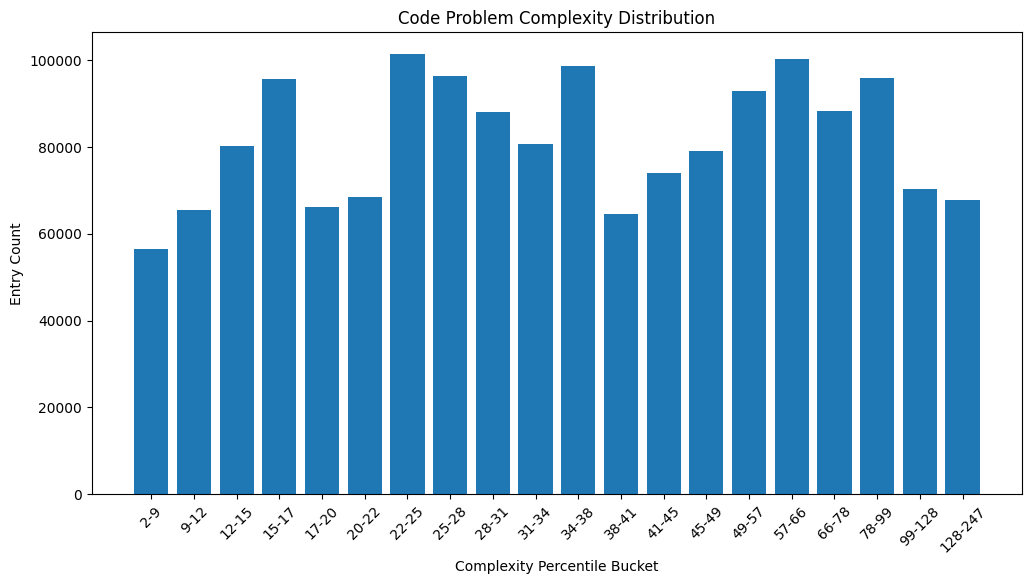

In [16]:

def plot_complexity_distribution(distribution):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(distribution['counts'])), distribution['counts'].values())
    plt.xlabel('Complexity Percentile Bucket')
    plt.ylabel('Entry Count')
    plt.title('Code Problem Complexity Distribution')
    plt.xticks(ticks=range(len(distribution['percentiles'])-1), 
               labels=[f"{int(distribution['percentiles'][i])}-{int(distribution['percentiles'][i+1])}" 
                       for i in range(len(distribution['percentiles'])-1)],
               rotation=45)
    plt.show()

plot_complexity_distribution(distribution)